In [7]:
import fastbook
fastbook.setup_book()

In [8]:
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *

In [9]:
# Downloading the data the usual way
path = untar_data(URLs.ML_100k)

# Extracting the Ratings
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user', 'movie', 'rating', 'timestamp'])

# Extracting the Movie Titles
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                    usecols=(0,1), names=('movie', 'title'), header=None)

# Merging the two dataframes
ratings = ratings.merge(movies)

# Creating our DataLoaders
dls = CollabDataLoaders.from_df(ratings,
                                 user_name='user',
                                 item_name='title',
                                 rating_name = 'rating',
                                 bs=64)

# Initialising our Latent Factors
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [10]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

# Collaborative Filtering Deep Dive

## Weight Decay

Weight decay, or `L2 regularisation` consists of adding to your loss function the sum of all the weights squared. When we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

The idea is that the larger coefficients are, the sharper canyons we will have in the loss function. If we take the basic example of a parabola, `y = a * (x**2`, the larger `a` is, the more *narrow* the parabola is.

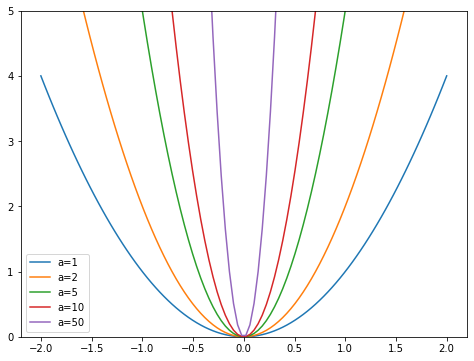

In [11]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

Letting our model learn high parameters might cause it to fit all the data points in the training set with an overcomplex function which leads to overfitting.
By limiting our weights from growing too much however, although it will hinder the training of the model, it will also yield a state where it generalises better. 

Going back to theory, weight decay `wd` is a parameter that controls that sum of squares we add to our loss.

``` python
loss_with_wd = loss + wd * (parameters**2).sum()
```

In practice, though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. If you remember a little bit of high school math, you might recall that the derivative of `p**2` with respect to `p` is `2*p`, so adding that big sum to our loss is exactly the same as doing:

``` python
parameters.grad += wd * 2 * parameters
```

In practice, since `wd` is a parameter that we choose, we can just make it twice as big, so we don't even need the `*2` in this equation. To use weight decay in fastai, just pass `wd` in your call to `fit` or `fit_one_cycle`:

In [12]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.926447,0.948356,00:03
1,0.865705,0.871087,00:03
2,0.720003,0.833099,00:03
3,0.617395,0.816588,00:03
4,0.501540,0.816793,00:03
